#**Part 5: human-learn**

###1. Titanic Dataset Rule-based Classification

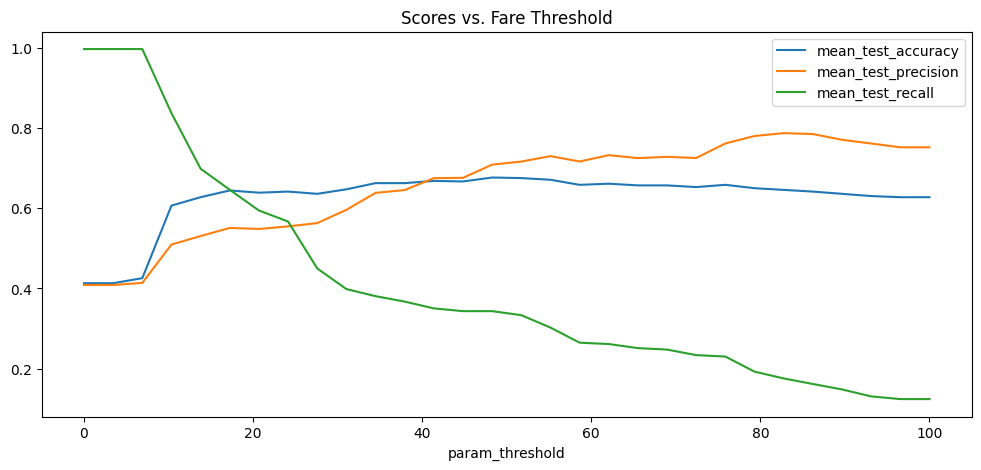

In [ ]:
# Load titanic dataset
from hulearn.datasets import load_titanic
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from hulearn.classification import FunctionClassifier

# Load and split
df = load_titanic(as_frame=True)
X, y = df.drop(columns=['survived']), df['survived']

# Define rule-based function
def fare_based(dataf, threshold=10):
    """Rule: Passengers who paid more may have higher survival chances."""
    return np.array(dataf['fare'] > threshold).astype(int)

# Wrap rule into scikit-learn compatible model
mod = FunctionClassifier(fare_based, threshold=10)

# Grid search over threshold values
grid = GridSearchCV(
    mod,
    cv=2,
    param_grid={'threshold': np.linspace(0, 100, 30)},
    scoring={
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score)
    },
    refit='accuracy'
)
grid.fit(X, y)

# Visualize
score_df = (
    pd.DataFrame(grid.cv_results_)
    .set_index('param_threshold')
    [['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']]
)

score_df.plot(figsize=(12, 5), title="Scores vs. Fare Threshold");


This method is very useful! We can also use it to make systems like;

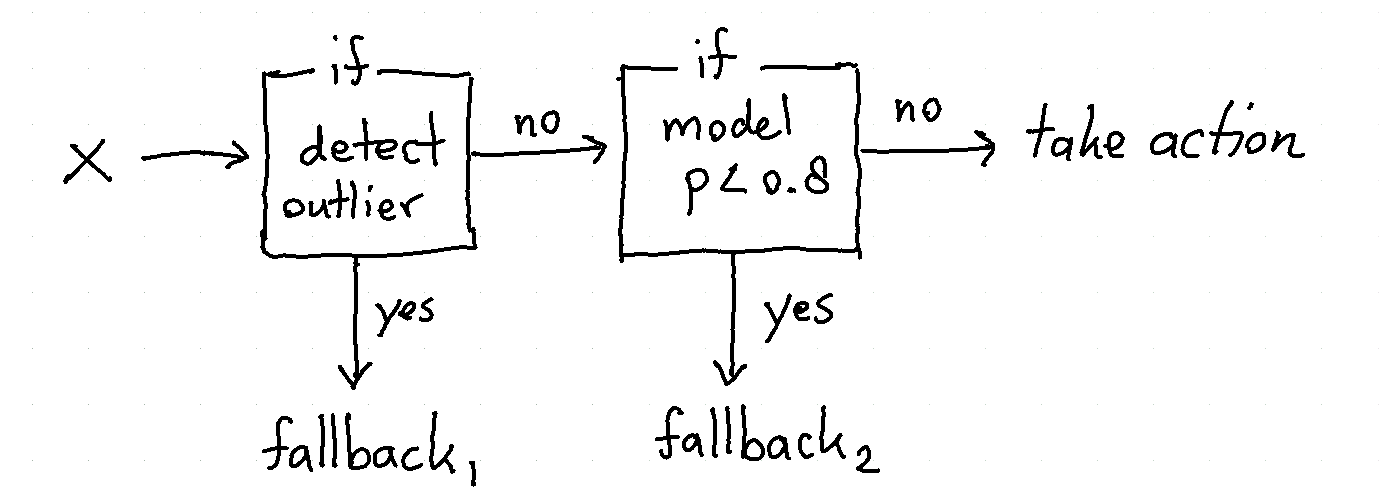

Here's the pseudo-code

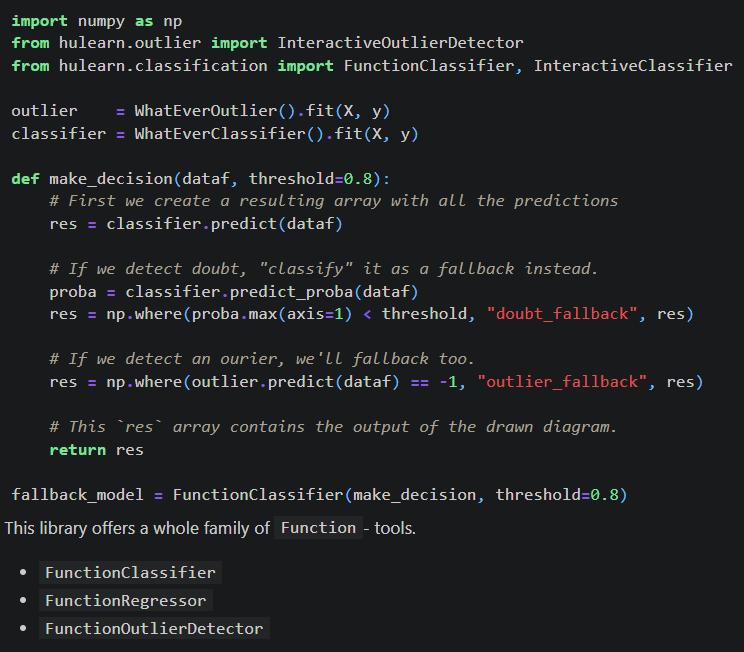

###2. Using Manual Classifier + Probabilities

In [ ]:
# Fallback system logic with manual classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest

# Train classifier and outlier detector
classifier = RandomForestClassifier().fit(X.select_dtypes(include=np.number), y)
outlier = IsolationForest().fit(X.select_dtypes(include=np.number))

def make_decision(dataf, threshold=0.8):
    probs = classifier.predict_proba(dataf.select_dtypes(include=np.number))
    res = classifier.predict(dataf.select_dtypes(include=np.number))

    # Add fallback for low-confidence predictions
    res = np.where(probs.max(axis=1) < threshold, -1, res)  # -1 = fallback

    # Add fallback for outliers
    outliers = outlier.predict(dataf.select_dtypes(include=np.number))
    res = np.where(outliers == -1, -2, res)  # -2 = outlier fallback

    return res

# Wrap it into FunctionClassifier for scikit-learn
fallback_model = FunctionClassifier(make_decision, threshold=0.8)

###3. Penguins Dataset

In [ ]:
import pandas as pd
from sklego.datasets import load_penguins
import plotly.express as px

# Load data
df = load_penguins(as_frame=True).dropna()
X, y = df.drop(columns='species'), df['species']

# Interactive feature-label exploration
fig1 = px.scatter(df, x="bill_length_mm", y="bill_depth_mm", color="species")
fig2 = px.scatter(df, x="flipper_length_mm", y="body_mass_g", color="species")

fig1.show()
fig2.show()

###4. Preprocessing

In [ ]:
from sklearn.preprocessing import FunctionTransformer

# Dummy transformer to simulate labeled groupings
def add_groups(dataf):
    dataf = dataf.copy()
    dataf['group_one'] = (dataf['flipper_length_mm'] > 190).astype(int)
    dataf['group_two'] = (dataf['body_mass_g'] > 4000).astype(int)
    return dataf

transformer = FunctionTransformer(add_groups)
df_transformed = transformer.fit_transform(df)
df_transformed.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,group_one,group_two
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,0,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,0,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,1,0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,1,0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,0,0
